## Imports 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit, transpile, QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix, Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from math import gcd

# Grover's Algorithm 

## Define our Oracle and target state (marked state)

In [ ]:
def quantum_oracle(num_qubits, marked_state):
    marked_state = marked_state[::-1]
    oracle = QuantumCircuit(num_qubits)
    
    """
     - Apply X gate on all 0 qubits in the marked state
    """
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)

    """
     - Apply hadamard gates on the last qubit 
     - flip the phase of the state if it is equal to the marked state using 
         multi controlled z-gate
    """
    control_qubits = list(range(num_qubits - 1))
    target_qubit = num_qubits - 1

    oracle.h(target_qubit)
    oracle.mcx(control_qubits, target_qubit)
    oracle.h(target_qubit)

    """
     - Undo the X Gates
    """    
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)
        
    return oracle

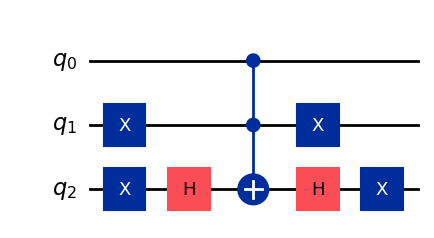

In [ ]:
oracle = quantum_oracle(3, "001")
oracle.draw('mpl')

## Define our Diffusion Operator

In [ ]:
# Diffusion operator (U_s)
def grover_diffusion_operator(num_qubits):

    """
     Initialise Diffusion Operator circuit :
        - This Operator amplifies the amplitude of the marked state 
          and suppresses the states that are not marked
        - # U_f = 2|ψ><ψ| - I
    """
    diff_operator = QuantumCircuit(num_qubits)

    """ 
    Hadamard Transform :
    Reflects phase about the average and amplifies the probability of the marked state
    """
    diff_operator.h(list(range(num_qubits)))
    diff_operator.x(list(range(num_qubits)))

    diff_operator.h(num_qubits - 1)
    diff_operator.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    diff_operator.h(num_qubits - 1)
    
    diff_operator.x(list(range(num_qubits)))
    diff_operator.h(list(range(num_qubits)))
    
    return diff_operator

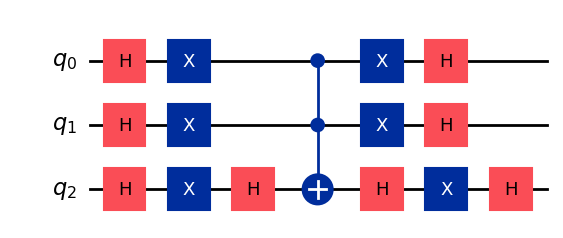

In [ ]:
U_f = grover_diffusion_operator(3)
U_f.draw('mpl')

## Circuit Initialization

In [ ]:
num_qubits = 3
marked_state = "011"

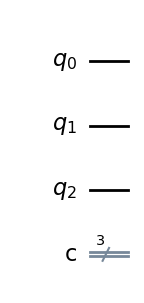

In [ ]:
qc = QuantumCircuit(num_qubits,num_qubits)
qc.draw('mpl')

In [ ]:
u = Statevector(qc)
u.draw('latex')

<IPython.core.display.Latex object>

## Introduce a uniform superposition of all basis states

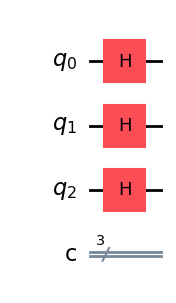

In [ ]:
qc.h(list(range(num_qubits)))
qc.draw('mpl')

In [ ]:
u = Statevector(qc)
u.draw('latex')

<IPython.core.display.Latex object>

## Measure and Find output counts 

In [ ]:
oracle = quantum_oracle(num_qubits, marked_state)
diffuser = grover_diffusion_operator(num_qubits)

In [ ]:
num_iterations = int(np.floor(np.pi/4 * np.sqrt(2**num_qubits)))
for i in range(num_iterations):
    qc.compose(oracle,inplace=True)
    qc.compose(diffuser,inplace=True)

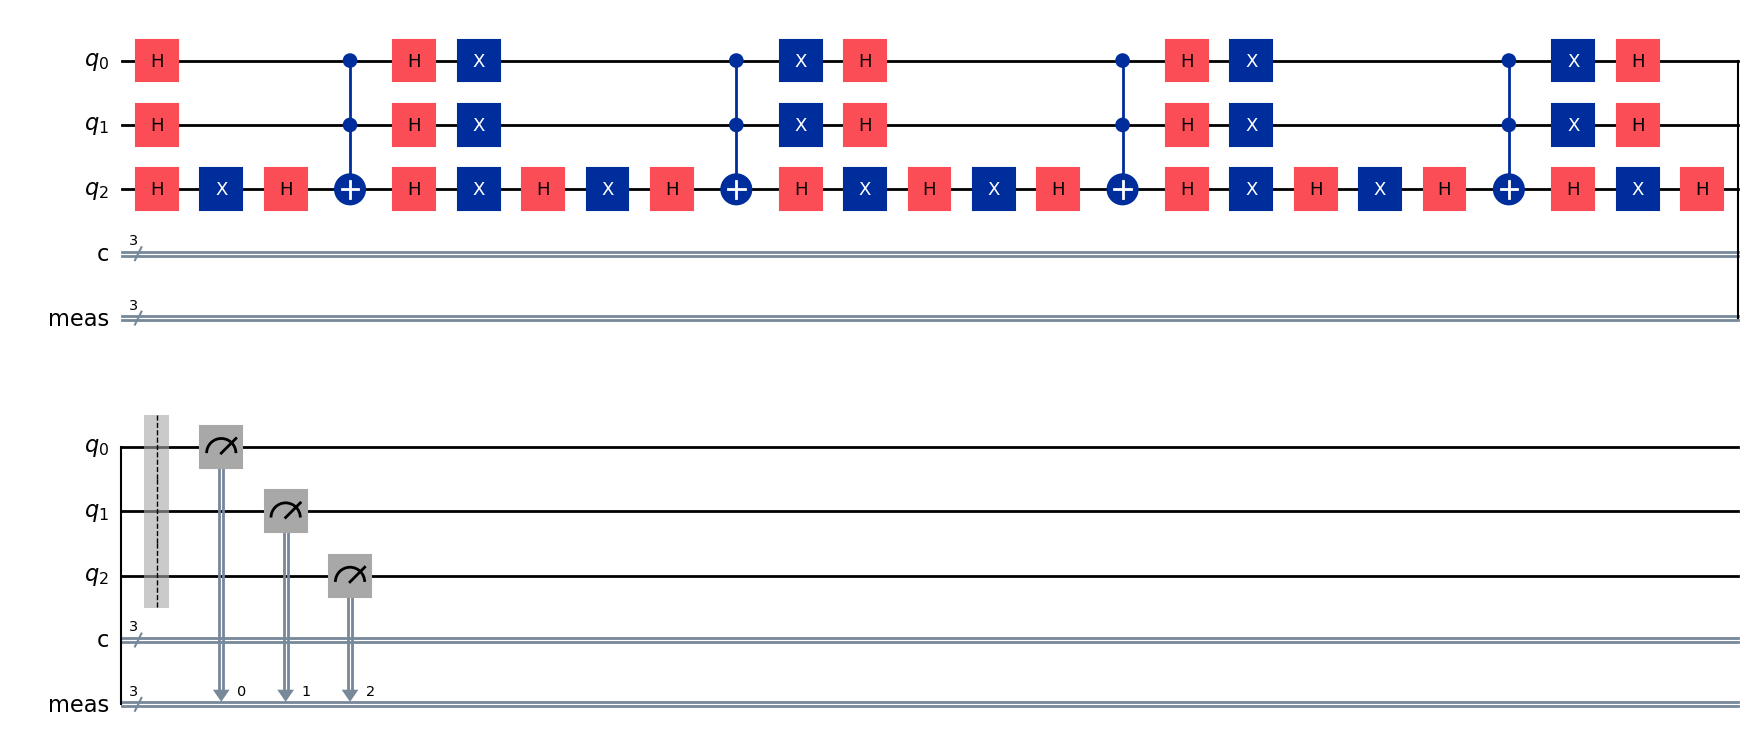

In [ ]:
qc.measure_all()
qc.draw('mpl')

In [ ]:
backend = AerSimulator()

job = backend.run(transpile(qc,backend), shots=1000)
result = job.result()

counts = result.get_counts()
print(counts)

{'010 000': 6, '011 000': 947, '001 000': 9, '101 000': 9, '100 000': 8, '000 000': 5, '111 000': 8, '110 000': 8}


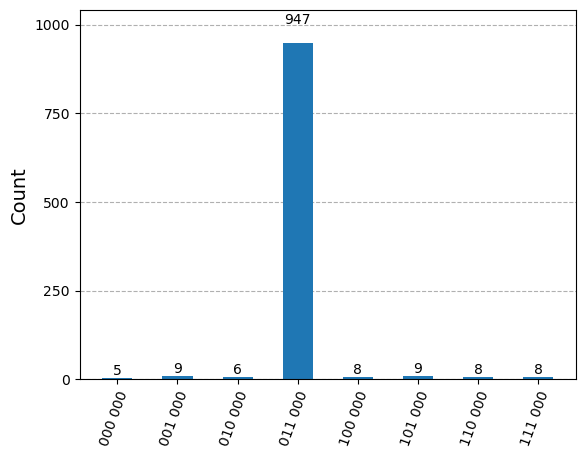

In [ ]:
plot_histogram(counts)

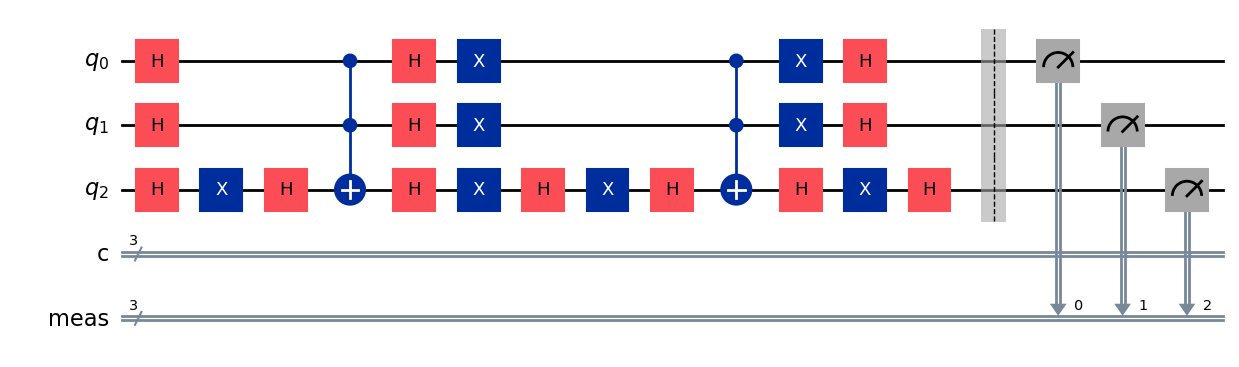

In [ ]:
sample_circuit = QuantumCircuit(3,3)
sample_circuit.h([0, 1, 2])
sample_circuit.compose(oracle, inplace=True)
sample_circuit.compose(diffuser, inplace=True)
sample_circuit.measure_all()
sample_circuit.draw('mpl')

# Shor's Algorithm

## Define Shor's circuit


In [ ]:
def shors_circuit(N):
    n = int(np.ceil(np.log2(N)))
    qc = QuantumCircuit(2*n, n)

    # Apply Hadamard gates to the first n qubits
    qc.h(range(n))

    # Apply the inverse Quantum Fourier Transform (QFT)
    qc.append(QFT(n).inverse(), range(n))

    # Measure the first n qubits
    qc.measure(range(n), range(n))
    return qc

### Sample shor's circuit

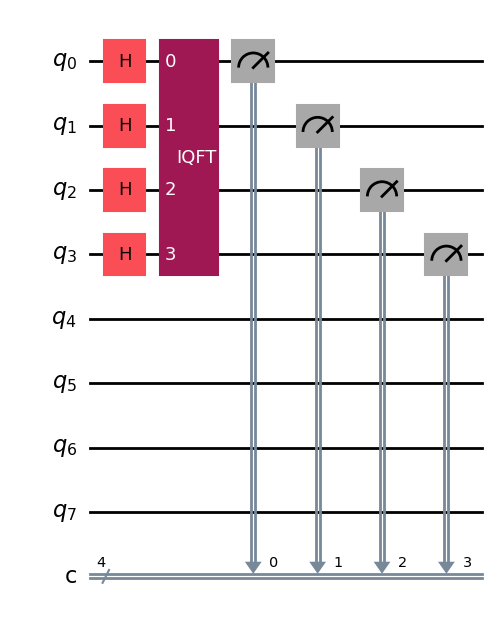

In [ ]:
sc = shors_circuit(15)
sc.draw('mpl')

## Define functions to calculate continued fractions and convergents

In [ ]:
def continued_fractions(a, b):
    frac = []
    while b!=0 :
        q = a // b
        frac.append(q)
        a, b = b, a%b
    return frac

In [ ]:
def convergents(frac):
    numerators = [0, 1]
    denominators = [1, 0]
    for q in frac:
        numerators.append(q * numerators[-1] + numerators[-2])
        denominators.append(q * denominators[-1] + denominators[-2])
    return list(zip(numerators[2:], denominators[2:]))

## Define Shor's algorithm protocol

In [ ]:
def shor(N): #Ensure N is not a prime or a power of a prime

    # Check trivial factors
    for i in range(2, int(np.sqrt(N)) + 1):
        if N % i == 0:
            return i, N // i
    
    # Choose a random integer a < N
    a = np.random.randint(2, N)
    if gcd(a, N) > 1:
        return gcd(a, N), N // gcd(a, N)

    # Define the quantum circuit for period finding
    qc = shors_circuit(N)
    
    # Simulate the quantum circuit
    backend = AerSimulator()
    job = backend.run(transpile(qc,backend), shots=1000)
    result = job.result()
    counts = result.get_counts()

    # Interpret the measurement result
    measured_value = int(max(counts, key=counts.get), 2)
    if measured_value == 0:
        return "Failed to find a period"

    # Find the period using continued fractions
    frac = continued_fractions(measured_value, 2**n)
    conv = convergents(frac)

    for _,r in conv:
        if r > 0 and pow(a, r, N) == 1:
            p1 = gcd(pow(a, r // 2) - 1, N)
            p2 = gcd(pow(a, r // 2) + 1, N)
            if p1 * p2 == N and p1 > 1 and p2 > 1:
                return p1, p2
    return "Failed to factorize"



In [ ]:
N = 49
result = shor(N)
print(f'Factors of {N} are : {result}')

Factors of 49 are : (7, 7)
